# Data Collection
## import the required libraries.

In [2]:
local_path = '../data/car_data'
# local_path = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data'
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
NVIDIA GeForce GTX 1660


# Going through the dataset
## Checking the number of each car we have in our dataset

In [ ]:
car_count_dict = {}
for folder_name in os.listdir(os.path.join(local_path, 'train')):
    count = len(os.listdir(os.path.join(local_path, 'train', folder_name)))
    car_count_dict[folder_name] = count

for folder_name in os.listdir(os.path.join(local_path, 'test')):
    count = len(os.listdir(os.path.join(local_path, 'test', folder_name)))
    car_count_dict[folder_name] += count

## Plotting the number of each car in each class

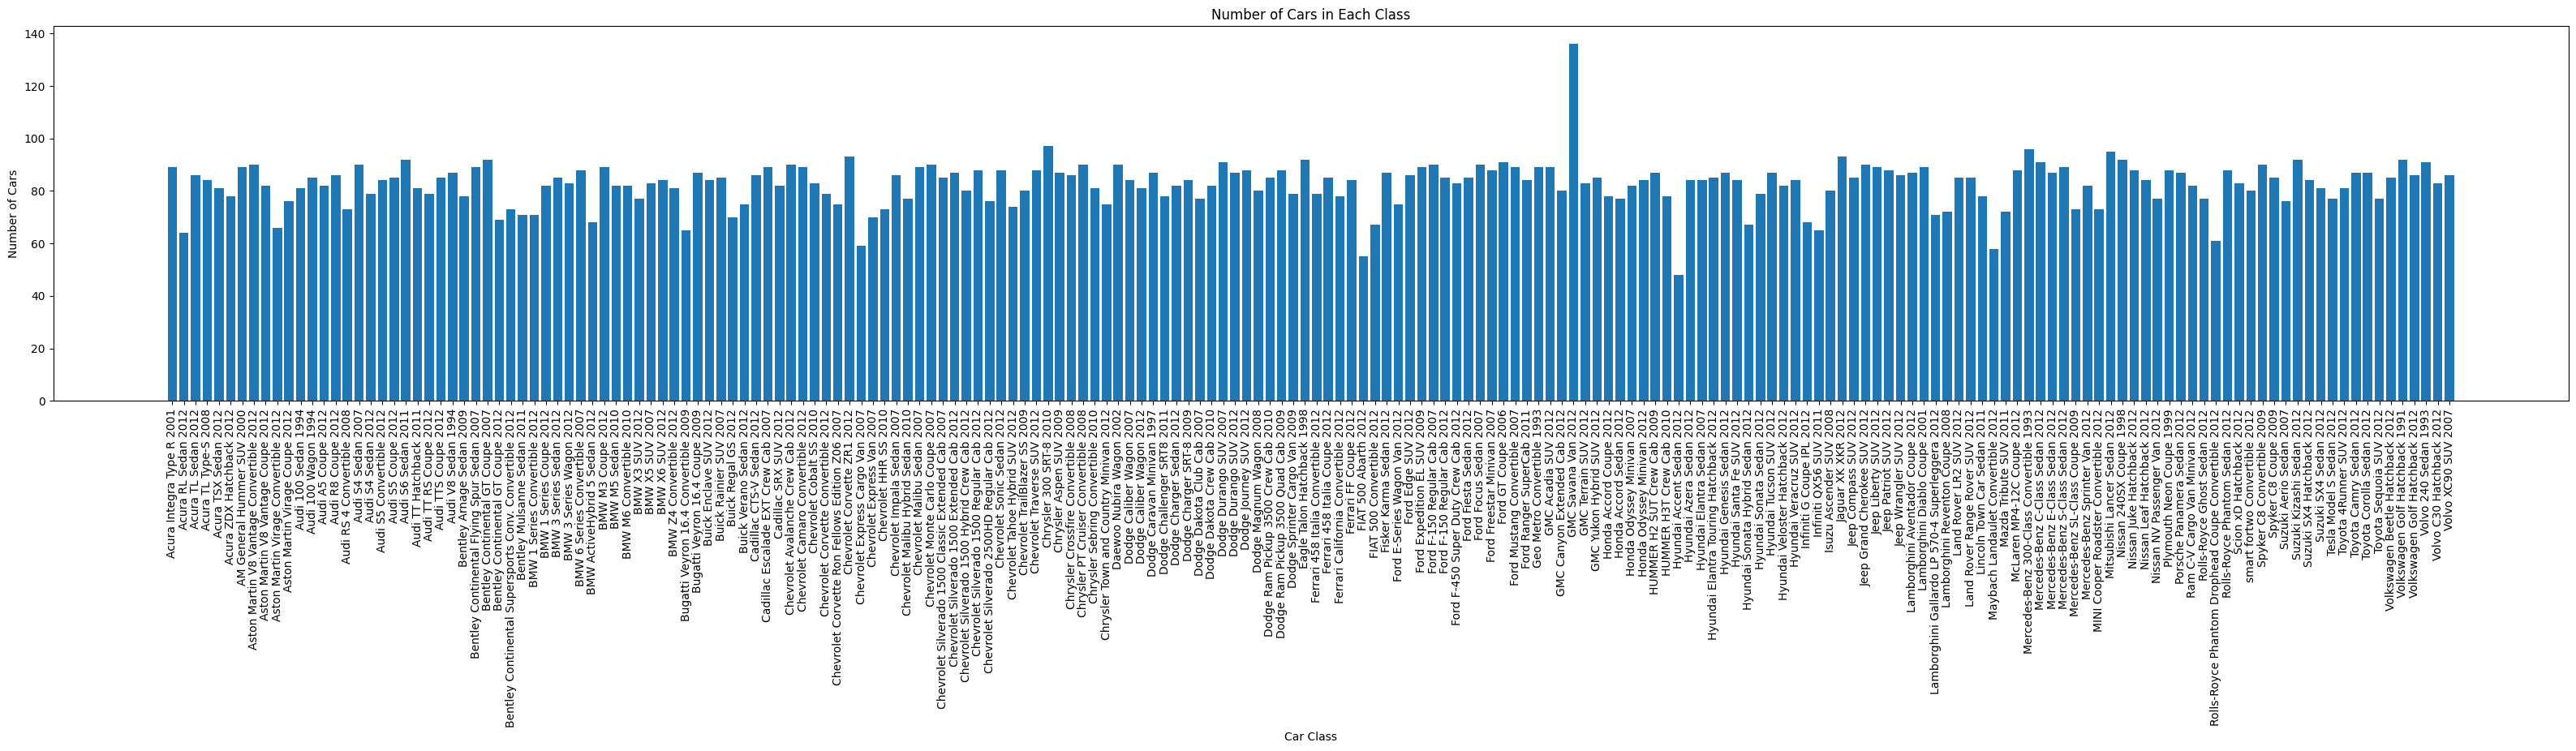

In [ ]:
plt.figure(figsize=(40, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class')

plt.xticks(rotation=90)

plt.show()

# Data Preprocessing and Data augmentation

## resizing, rotation, flipping, and normalizing the dataset

In [4]:
dataset_dir = local_path

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_time_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform = train_tfms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2)

test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'test'), transform = test_tfms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2)

# Model Creation and Transfer Learning

## using the pre-trained model and replacing the last fully connected layer with a new one

In [ ]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
no_classes = len(train_dataset.classes)
model.parameters

d:\My Project\CarModel\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\My Project\CarModel\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\nphuo/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 15.4MB/s]


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


##  replace the last fc layer

In [ ]:
model.fc = nn.Linear(num_ftrs, no_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

# Evaluation Step

In [ ]:
import torch
from tqdm import tqdm

def eval_model(model, test_loader, device, test_time_tsfm=None, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            if test_time_tsfm is not None:
                augmented_images = []
                for img in images:
                    augmented_images.extend(img)
                    augmented_imgs = [test_time_tsfm(img) for _ in range(num_augmentations)]
                    augmented_images.extend(augmented_imgs)
                images = torch.stack(augmented_images)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * num_augmentations
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    # Calculate the accuracy
    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

# Training Step

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

##  call the function to start training the model

In [11]:
n_epochs = 10
# train the model
model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)
# Save the model
torch.save(model.state_dict(), 'model.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, duration: 207 s, loss: 4.0325, acc: 14.0809


 10%|█         | 1/10 [05:22<48:20, 322.33s/it]

Accuracy of the network on the test images: 31 %
Epoch 2, duration: 197 s, loss: 1.7169, acc: 54.9020


 20%|██        | 2/10 [10:08<40:08, 301.06s/it]

Accuracy of the network on the test images: 57 %
Epoch 3, duration: 195 s, loss: 0.8860, acc: 75.9681


 30%|███       | 3/10 [14:52<34:12, 293.25s/it]

Accuracy of the network on the test images: 64 %
Epoch 4, duration: 198 s, loss: 0.5440, acc: 84.6324


 40%|████      | 4/10 [19:38<29:01, 290.23s/it]

Accuracy of the network on the test images: 74 %
Epoch 5, duration: 196 s, loss: 0.3537, acc: 90.0490


 50%|█████     | 5/10 [24:23<24:03, 288.62s/it]

Accuracy of the network on the test images: 82 %
Epoch 6, duration: 198 s, loss: 0.2367, acc: 93.6887


 60%|██████    | 6/10 [29:10<19:11, 287.86s/it]

Accuracy of the network on the test images: 81 %
Epoch 7, duration: 193 s, loss: 0.1645, acc: 95.8211


 70%|███████   | 7/10 [33:46<14:12, 284.02s/it]

Accuracy of the network on the test images: 85 %
Epoch 8, duration: 197 s, loss: 0.0795, acc: 98.1863


 80%|████████  | 8/10 [38:36<09:32, 286.03s/it]

Accuracy of the network on the test images: 90 %
Epoch 9, duration: 198 s, loss: 0.0552, acc: 98.7500


 90%|█████████ | 9/10 [43:25<04:46, 286.82s/it]

Accuracy of the network on the test images: 90 %
Epoch 10, duration: 191 s, loss: 0.0480, acc: 98.9951


100%|██████████| 10/10 [48:09<00:00, 288.90s/it]

Accuracy of the network on the test images: 90 %
Finished Training


## plot the training and validation results.

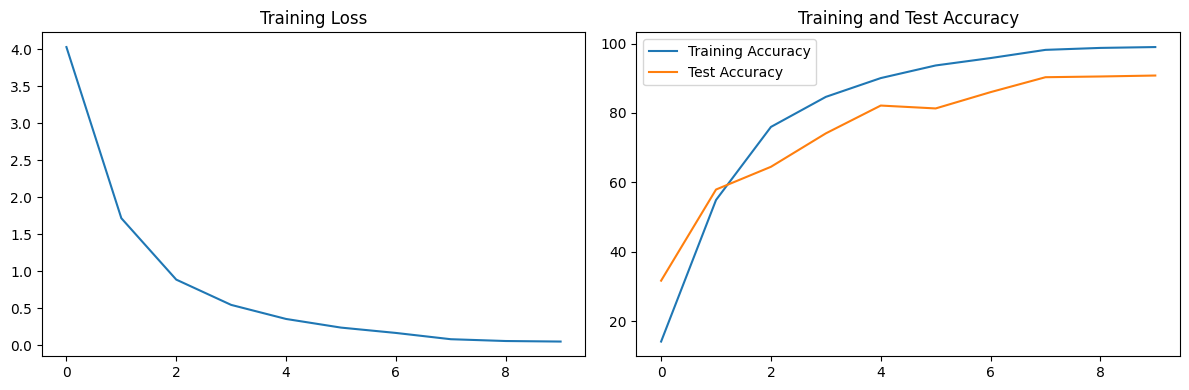

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

# Test Time Evaluation Step

## evaluating the model 

In [5]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(os.path.join(dataset_dir, 'train'))

## Save class labels to a file

In [ ]:

with open('classes.txt', 'w') as f:
    for class_name in classes:
        f.write(f"{class_name}\n")


##  calculate these results for each class in our dataset.

In [ ]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)

cr = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

Confusion Matrix:
[[42  0  0 ...  0  0  0]
 [ 0 39  0 ...  0  0  0]
 [ 0  0 26 ...  0  0  0]
 ...
 [ 0  0  0 ... 38  0  0]
 [ 0  0  0 ...  0 43  0]
 [ 0  0  0 ...  0  0 39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        44
           1       0.85      0.89      0.87        44
           2       0.96      0.81      0.88        32
           3       0.82      0.98      0.89        43
           4       0.98      0.98      0.98        42
           5       1.00      0.90      0.95        40
           6       0.95      0.90      0.92        39
           7       0.83      0.78      0.80        45
           8       0.86      0.73      0.79        41
           9       0.76      0.88      0.82        33
          10       0.83      0.89      0.86        38
          11       0.72      0.82      0.77        40
          12       0.87      0.79      0.82        42
          13       0.78      0.88      0.83  

##  test the model performance on random images.

In [14]:

model.eval()


loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = 'Aston Martin V8 Vantage Convertible 2012/00239.jpg'
image = Image.open(os.path.join(dataset_dir, 'test', random_image_name))

image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)

image = image.unsqueeze(0)
image = image.cuda()
output = model(image)

conf, predicted = torch.max(output.data, 1)

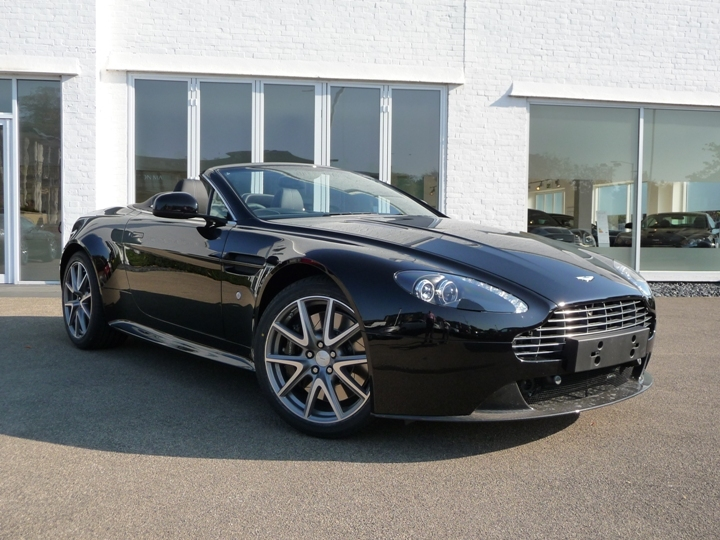

Aston Martin V8 Vantage Convertible 2012 confidence:  16.056896209716797


In [15]:
display(Image.open(os.path.join(dataset_dir, 'test', random_image_name)))
print(classes[predicted.item()], "confidence: ", conf.item())